# Machine Learning
*by Jonathan Frawley*

# Traditional AI
 - Rules-based
 - Programmer writes rules to represent the world
 - Simulate how rules behave in different situations

### Unsupervised Machine Learning
 - Learn about dataset in an automated way
 - Clustering

### Supervised Machine Learning
 - Learn how to accomplish a task automatically from data
 - aka - deep learning


# Unsupervised Machine Learning

## Clustering

<img style="text-align: center;" src="https://www.guru99.com/images/1/030819_1030_Unsupervise3.png" alt="Clustering" width="800"/>

### K-Means Clustering
<img style="text-align: center;" src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" alt="K-Means Clustering" width="600"/>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import NearestCentroid

n_neighbors = 15

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

In [4]:
# we create an instance of Neighbours Classifier and fit the data.
clf = NearestCentroid(shrink_threshold=None)
clf.fit(X, y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
clf.centroids_

array([[5.006, 3.428],
       [5.936, 2.77 ],
       [6.588, 2.974]])

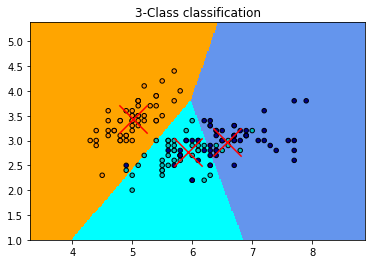

In [3]:
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.scatter(clf.centroids_[:, 0], clf.centroids_[:, 1],
            c="red", edgecolor='black', marker='x', s=800)

plt.title("3-Class classification")
plt.axis('tight')

plt.show()

# Supervised Machine Learning

# Deep Learning
<img style="text-align: center;" src="https://www.extremetech.com/wp-content/uploads/2015/09/sat-ai-head.jpg" alt="AI" width="300"/>

 - Data is at centre
 - Programs learn solution based on data provided
 - More specifically, programs learn probability distribution of data provided
 - Fundamental ideas have been around for many decades, but in the last 10 years hardware has made it more feasible

<img style="text-align: center;" src="https://miro.medium.com/max/1400/1*_7OPgojau8hkiPUiHoGK_w.png" alt="AI" width="800"/>


## Deep Learning Applications

### Self-Driving Cars

<img style="text-align: center;" src="https://miro.medium.com/proxy/1*q1uVc-MU-tC-WwFp2yXJow.gif" alt="Self-driving car" width="800"/>


## Transformer Example
 - GPT-2: https://talktotransformer.com/

### Example:
**Betsy was a pig who lived in Devon, she was taken care of by** a local hunter. His wife Sarah lived with her in the same house. When Betsy died, Sarah, her daughter Emily, and her son Paul were left to care for the farm and its pigs. They were all too well versed in the ways of caring for a farm. They taught us all how to care for pigs. Betsy's spirit is alive today in Betsy's Family, and Emily, Chris, and Paul call her Betsy. They frequently speak about Betsy, who they believe is still with them. Betsy passed away in December, 2011. However, Betsy is now with Jesus, and at his right hand. So we sing this song with that and with our thanksgiving of


## Medical Imaging

<img style="text-align: center;" src="https://miro.medium.com/max/1322/1*QbgD1Mkw6l0NRsGMi32yRA.png" alt="Self-driving car" width="800"/>


## Other applications
 - Speech-to-text
 - Text-to-speech
 - Customer support
 - Navigation
 - Search results
 - Product listings
 - DeepFakes
 - Face detection

## Deep Learning Challenges

 - Difficult to know "how" decision is arrived at
 - Generally require a large dataset to come to a good solution
 - Computationally expensive - though new hardware is helping
 - No consensus yet on universally "good" models for particular applications
 - Open datasets are rare, especially in medical imaging

# Deep Learning Basic Terminology
 - Tensors: N-Dimensional Matrices
 - Model: The learned program
 - Convolution
 - Convolutional Neural Network
 - Dataset
 - Loss: How far are we from goal
 - Optimizer: Modify model given loss
 - We talk about solutions in terms of probability distributions

# Convolutional Neural Networks


<img style="text-align: center;" src="https://miro.medium.com/max/256/0*qT8D07uyUdf3SDac.gif" alt="Self-driving car" width="400"/>


<img style="text-align: center;" src="https://miro.medium.com/max/1400/1*bsM9XDMRfE9O8_hy2ArsQQ.png" alt="Self-driving car" width="800"/>


## Convolution
<img style="text-align: center;" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" alt="Convolution" width="300"/>

## Transpose Convolution (Or "Up-convolution")
<img style="text-align: center;" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides_transposed.gif" alt="Convolution" width="300"/>


<img style="text-align: center;" src="https://www.researchgate.net/profile/Brendan_Colvert/publication/319622643/figure/fig1/AS:537248807960576@1505101505202/Architecture-of-the-neural-network-consisting-of-four-successive-layers-a-linear-layer.png" alt="Neural Net" width="700"/>


## Measuring Performance

<img style="text-align: center;" src="https://miro.medium.com/max/1400/0*hgbfL5uJPVvfcAMf.png" alt="Self-driving car" width="800"/>


## Your First Deep Learning Model

### MNIST
<img style="text-align: center;" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" alt="MNIST" width="800"/>

In [ ]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 1
GAMMA = 0.7
RANDOM_SEED = 1

In [ ]:
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)


In [ ]:
EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100


for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [ ]:
test_loss = 0
total = 0
correct = 0
images = None
preds = None
with torch.no_grad():
    for batch_idx in range(TEST_ITER_PER_EPOCH):
        (data, target) = next(test_iter)

        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.shape[0]
        images = data.cpu()
        preds = pred.cpu().numpy()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))

In [ ]:
print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(num_of_images):
    plt.subplot(8, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Preds:")
for i in range(8):
    for j in range(8):
        print(preds[i*8+j].item(), end=',')
    print()

## Resources
 - Deep learning Book: https://www.deeplearningbook.org/
 - PyTorch: https://pytorch.org/tutorials/
 - Random forests: https://towardsdatascience.com/understanding-random-forest-58381e0602d2
 - Underfitting and overfitting image (accessed on 2019-06-06): https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76
 - Understanding convolutions: https://github.com/vdumoulin/conv_arithmetic